# ============================================================
# IMPORTS AND SETUP
# ============================================================

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models
import numpy as np
import time
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

# ============================================================
# CONFIGURATION
# ============================================================

In [2]:
DATA_PATH = "/kaggle/input/arsenic/Original_Data"  
IMAGE_SIZE = 224
BATCH = 32
EPOCHS = 50
LR = 0.01
TEMP = 0.1


# ---------------- AUGMENTATIONS ----------------

In [3]:
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.2,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    transforms.RandomGrayscale(0.2),
    transforms.GaussianBlur(23),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

test_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

class TwoCrop:
    """Return two augmented views for SimCLR."""
    def __init__(self, t): self.t = t
    def __call__(self, x): return self.t(x), self.t(x)

# ---------------- 80/20 SPLIT ----------------

In [4]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets

# Define the TransformedSubset class
class TransformedSubset(torch.utils.data.Dataset):
    """Wrapper to apply a transform to a Subset dataset."""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


# Load the full dataset (without initial transform)
full_ds = datasets.ImageFolder(DATA_PATH)

n = len(full_ds)
n_test = int(0.2 * n)
n_val = int(0.1 * n) # 10% of total
n_train = n - n_test - n_val

# Perform random_split
train_subset, val_subset, test_subset = random_split(full_ds, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42))

# Apply transforms using the wrapper
train_ds_with_transform = TransformedSubset(train_subset, transform=TwoCrop(train_tf))
val_ds_with_transform = TransformedSubset(val_subset, transform=test_tf) # Validation usually uses test_tf
test_ds_with_transform = TransformedSubset(test_subset, transform=test_tf)

# Create DataLoaders
train_loader = DataLoader(train_ds_with_transform, BATCH, shuffle=True)
val_loader  = DataLoader(val_ds_with_transform,  BATCH, shuffle=False)
test_loader  = DataLoader(test_ds_with_transform,  BATCH, shuffle=False)

num_classes = len(full_ds.classes)
print(f"Number of classes detected: {num_classes}")

# Print split sizes
print(f"Train size: {len(train_ds_with_transform)}")
print(f"Validation size: {len(val_ds_with_transform)}")
print(f"Test size: {len(test_ds_with_transform)}")

Number of classes detected: 2
Train size: 902
Validation size: 128
Test size: 257


# ---------------- MODEL (ResNet50 backbone) ----------------

In [5]:
class ResNet50Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        m = models.resnet50(weights=None)
        self.features = nn.Sequential(*list(m.children())[:-1])
        self.feat_dim = 2048

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x


class Projector(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 2048),
            nn.ReLU(),
            nn.Linear(2048, 128)
        )
    def forward(self, x): return F.normalize(self.net(x), dim=1)

backbone = ResNet50Backbone()
proj = Projector(backbone.feat_dim)


# ---------------- NT-Xent LOSS ----------------

In [6]:
def nt_xent(z1, z2, temp=TEMP):
    N = z1.size(0)
    z = torch.cat([z1, z2], 0)
    sim = torch.matmul(z, z.t()) / temp
    mask = (~torch.eye(2*N, dtype=bool))
    exp_sim = torch.exp(sim) * mask
    pos = torch.exp((z1 * z2).sum(1) / temp)
    pos = torch.cat([pos, pos])
    denom = exp_sim.sum(1)
    return (-torch.log(pos / denom)).mean()



# ---------------- MAE TRAINING ----------------

In [7]:
print("\n========== MAE PRETEXT TRAINING ==========")

optimizer = torch.optim.SGD(
    list(backbone.parameters()) + list(proj.parameters()),
    lr=LR, momentum=0.9
)

pretext_losses = []
start = time.time()

for epoch in range(1, EPOCHS + 1):
    running = 0

    for batch in tqdm(train_loader):

        # --------------------------
        # BATCH AUTO-FIX UNPACKING
        # --------------------------

        # If batch = ((x1, x2), y)
        if isinstance(batch, (list, tuple)) and len(batch) == 2:
            views, _ = batch
            if isinstance(views, (list, tuple)) and len(views) == 2:
                x1, x2 = views
            else:
                x1, x2 = batch   # fallback

        # If batch = (x1, x2)
        elif isinstance(batch, (list, tuple)) and len(batch) == 2:
            x1, x2 = batch

        # If batch = (x1, x2, y)
        elif isinstance(batch, (list, tuple)) and len(batch) == 3:
            x1, x2, _ = batch

        else:
            raise ValueError(f"Unknown batch format: {batch}")

        # --------------------------
        # FORWARD PASS
        # --------------------------
        f1, f2 = backbone(x1), backbone(x2)
        z1, z2 = proj(f1), proj(f2)

        loss = nt_xent(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item()

    epoch_loss = running / len(train_loader)
    pretext_losses.append(epoch_loss)

    print(f"Epoch {epoch} Loss = {epoch_loss:.4f}")

pretrain_time = time.time() - start



========== MAE PRETEXT TRAINING ==========


100%|██████████| 29/29 [09:26<00:00, 19.52s/it]


Epoch 1 Loss = 4.0071


100%|██████████| 29/29 [08:39<00:00, 17.92s/it]


Epoch 2 Loss = 3.9592


100%|██████████| 29/29 [08:42<00:00, 18.01s/it]


Epoch 3 Loss = 3.9227


100%|██████████| 29/29 [08:41<00:00, 18.00s/it]


Epoch 4 Loss = 3.8954


100%|██████████| 29/29 [08:44<00:00, 18.07s/it]


Epoch 5 Loss = 3.8442


100%|██████████| 29/29 [08:49<00:00, 18.26s/it]


Epoch 6 Loss = 3.8015


100%|██████████| 29/29 [08:45<00:00, 18.10s/it]


Epoch 7 Loss = 3.7921


100%|██████████| 29/29 [08:47<00:00, 18.20s/it]


Epoch 8 Loss = 3.9987


100%|██████████| 29/29 [08:48<00:00, 18.23s/it]


Epoch 9 Loss = 3.7406


100%|██████████| 29/29 [08:49<00:00, 18.24s/it]


Epoch 10 Loss = 3.6411


100%|██████████| 29/29 [08:46<00:00, 18.17s/it]


Epoch 11 Loss = 3.5969


100%|██████████| 29/29 [08:47<00:00, 18.18s/it]


Epoch 12 Loss = 3.4980


100%|██████████| 29/29 [08:45<00:00, 18.13s/it]


Epoch 13 Loss = 3.3352


100%|██████████| 29/29 [08:46<00:00, 18.14s/it]


Epoch 14 Loss = 3.3411


100%|██████████| 29/29 [08:47<00:00, 18.21s/it]


Epoch 15 Loss = 3.2553


100%|██████████| 29/29 [08:38<00:00, 17.88s/it]


Epoch 16 Loss = 3.1189


100%|██████████| 29/29 [08:33<00:00, 17.71s/it]


Epoch 17 Loss = 3.0042


100%|██████████| 29/29 [08:39<00:00, 17.91s/it]


Epoch 18 Loss = 3.0284


100%|██████████| 29/29 [08:39<00:00, 17.92s/it]


Epoch 19 Loss = 2.9945


100%|██████████| 29/29 [08:48<00:00, 18.22s/it]


Epoch 20 Loss = 2.8876


100%|██████████| 29/29 [08:45<00:00, 18.11s/it]


Epoch 21 Loss = 2.8596


100%|██████████| 29/29 [08:45<00:00, 18.13s/it]


Epoch 22 Loss = 2.8247


100%|██████████| 29/29 [08:44<00:00, 18.08s/it]


Epoch 23 Loss = 2.7788


100%|██████████| 29/29 [08:49<00:00, 18.25s/it]


Epoch 24 Loss = 2.6807


100%|██████████| 29/29 [08:44<00:00, 18.07s/it]


Epoch 25 Loss = 2.6134


100%|██████████| 29/29 [08:43<00:00, 18.06s/it]


Epoch 26 Loss = 2.6346


100%|██████████| 29/29 [08:37<00:00, 17.86s/it]


Epoch 27 Loss = 2.7297


100%|██████████| 29/29 [08:37<00:00, 17.83s/it]


Epoch 28 Loss = 2.5589


100%|██████████| 29/29 [08:36<00:00, 17.80s/it]


Epoch 29 Loss = 2.5803


100%|██████████| 29/29 [08:35<00:00, 17.79s/it]


Epoch 30 Loss = 2.4852


100%|██████████| 29/29 [08:43<00:00, 18.05s/it]


Epoch 31 Loss = 2.4726


100%|██████████| 29/29 [08:44<00:00, 18.09s/it]


Epoch 32 Loss = 2.7550


100%|██████████| 29/29 [08:47<00:00, 18.19s/it]


Epoch 33 Loss = 2.4861


100%|██████████| 29/29 [08:45<00:00, 18.13s/it]


Epoch 34 Loss = 2.3916


100%|██████████| 29/29 [08:49<00:00, 18.25s/it]


Epoch 35 Loss = 2.3893


100%|██████████| 29/29 [08:50<00:00, 18.28s/it]


Epoch 36 Loss = 2.3840


100%|██████████| 29/29 [08:52<00:00, 18.36s/it]


Epoch 37 Loss = 2.3617


100%|██████████| 29/29 [08:47<00:00, 18.20s/it]


Epoch 38 Loss = 2.3045


100%|██████████| 29/29 [08:46<00:00, 18.16s/it]


Epoch 39 Loss = 2.3816


100%|██████████| 29/29 [08:45<00:00, 18.13s/it]


Epoch 40 Loss = 2.3490


100%|██████████| 29/29 [08:43<00:00, 18.04s/it]


Epoch 41 Loss = 2.3589


100%|██████████| 29/29 [08:45<00:00, 18.12s/it]


Epoch 42 Loss = 2.2348


100%|██████████| 29/29 [08:37<00:00, 17.85s/it]


Epoch 43 Loss = 2.2756


100%|██████████| 29/29 [08:37<00:00, 17.85s/it]


Epoch 44 Loss = 2.3253


100%|██████████| 29/29 [08:39<00:00, 17.90s/it]


Epoch 45 Loss = 2.2055


100%|██████████| 29/29 [08:37<00:00, 17.83s/it]


Epoch 46 Loss = 2.2097


100%|██████████| 29/29 [08:37<00:00, 17.83s/it]


Epoch 47 Loss = 2.1961


100%|██████████| 29/29 [08:41<00:00, 17.98s/it]


Epoch 48 Loss = 2.1251


100%|██████████| 29/29 [08:45<00:00, 18.13s/it]


Epoch 49 Loss = 2.1186


100%|██████████| 29/29 [08:41<00:00, 17.99s/it]

Epoch 50 Loss = 2.0939


# Save frozen encoder

Saved → saved/frozen_encoder.pth


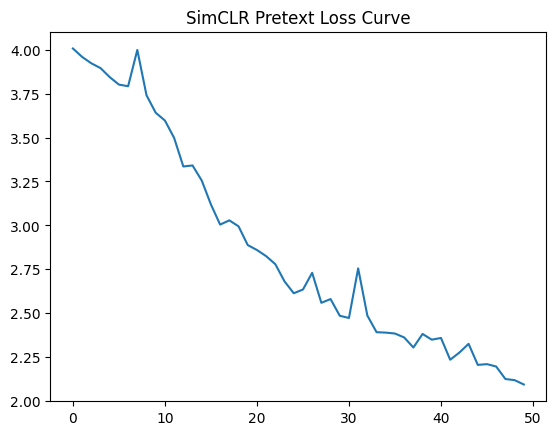

In [8]:
import os
os.makedirs("saved", exist_ok=True)
torch.save(backbone.state_dict(), "saved/frozen_encoder.pth")
print("Saved → saved/frozen_encoder.pth")

# Plot pretext curve
plt.plot(pretext_losses)
plt.title("SimCLR Pretext Loss Curve")
plt.savefig("pretext_curve.png")



# ============================================================
# PART B — DOWNSTREAM EVALUATION
# ============================================================

In [9]:

print("\n\n========== DOWNSTREAM EVALUATION ==========")

from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt



========== DOWNSTREAM EVALUATION ==========


2025-12-10 20:55:42.178720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765400142.360396      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765400142.412206      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# -------- FEATURE EXTRACTION --------

In [10]:
def extract_features(loader):
    feats=[]; labs=[]
    with torch.no_grad():
        for x,y in loader:
            # If x is a tuple (two views from TwoCrop), take the first view
            if isinstance(x, (list, tuple)) and len(x) == 2:
                x = x[0]
            feats.append(backbone(x).cpu().numpy())
            labs.append(y.cpu().numpy())
    return np.concatenate(feats), np.concatenate(labs)

print("Extracting features...")
train_feats, train_labels = extract_features(train_loader)
val_feats, val_labels = extract_features(val_loader)
test_feats, test_labels = extract_features(test_loader)

print(f"Train features shape: {train_feats.shape}")
print(f"Test features shape: {test_feats.shape}")


Extracting features...
Train features shape: (902, 2048)
Test features shape: (257, 2048)


# -------- LINEAR PROBE --------

In [11]:
sc = StandardScaler().fit(train_feats)
clf = LogisticRegression(max_iter=1000)
clf.fit(sc.transform(train_feats), train_labels)
pred = clf.predict(sc.transform(test_feats))
proba = clf.predict_proba(sc.transform(test_feats))[:,1]

# Metrics
acc = accuracy_score(test_labels, pred)
prec, rec, f1, _ = precision_recall_fscore_support(test_labels, pred, average="binary")
cm = confusion_matrix(test_labels, pred)
per_class_acc = cm.diagonal() / cm.sum(1)


# SHALLOW HEADS — Using Frozen Features from SimCLR Encoder

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

print("\n===== Shallow Heads Evaluation =====")

# ------------------------------------
# SCALE FEATURES
# ------------------------------------
scaler = StandardScaler().fit(train_feats)
X_train = scaler.transform(train_feats)
X_test  = scaler.transform(test_feats)

# ------------------------------------
# DEFINE SHALLOW MODELS
# ------------------------------------
shallow_models = {
    "MLP": MLPClassifier(hidden_layer_sizes=(256,), max_iter=300),
    "SVM (Linear)": SVC(kernel="linear", probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200),
}

# ------------------------------------
# TRAIN & TEST SHALLOW HEADS
# ------------------------------------
shallow_results = {}

for name, model in shallow_models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train, train_labels)
    acc = model.score(X_test, test_labels)
    shallow_results[name] = acc
    print(f"{name} Accuracy = {acc:.4f}")

# ------------------------------------
# PRINT FINAL RESULTS
# ------------------------------------
print("\n===== FINAL SHALLOW HEADS RESULTS =====")
for name, acc in shallow_results.items():
    print(f"{name}: {acc:.4f}")


===== Shallow Heads Evaluation =====

Training MLP ...
MLP Accuracy = 0.7121

Training SVM (Linear) ...
SVM (Linear) Accuracy = 0.7198

Training Decision Tree ...
Decision Tree Accuracy = 0.6187

Training Random Forest ...
Random Forest Accuracy = 0.7510

===== FINAL SHALLOW HEADS RESULTS =====
MLP: 0.7121
SVM (Linear): 0.7198
Decision Tree: 0.6187
Random Forest: 0.7510


# ROC curve

In [13]:
fpr, tpr, _ = roc_curve(test_labels, proba)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.savefig("roc_curve.png")
plt.close()

# Confusion matrix
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.savefig("confusion_matrix.png")
plt.close()

print("\nLinear Probe Accuracy =", acc)
print("Precision =", prec)
print("Recall =", rec)
print("F1 =", f1)
print("Per-class Accuracy =", per_class_acc)
print("ROC-AUC =", auc_score)



Linear Probe Accuracy = 0.7509727626459144
Precision = 0.6388888888888888
Recall = 0.7040816326530612
F1 = 0.6699029126213593
Per-class Accuracy = [0.75471698 0.70408163]
ROC-AUC = 0.8013733795404954


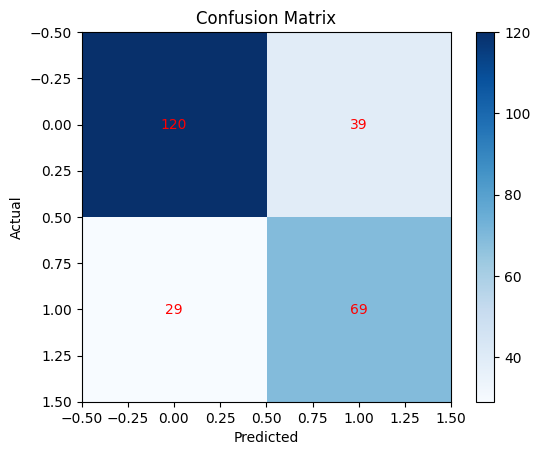

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

# value annotate (optional)
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, cm[i][j], ha="center", va="center", color="red")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


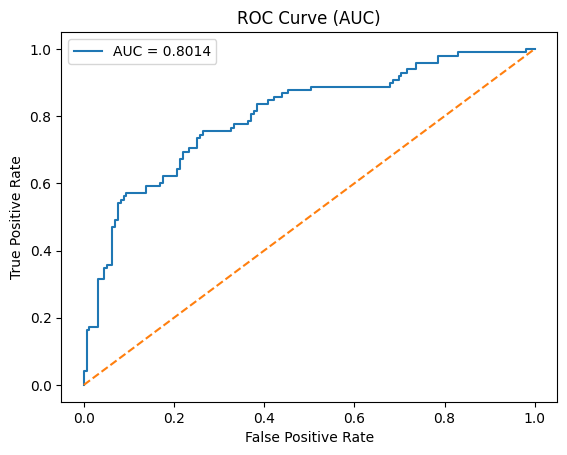

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (AUC)")
plt.legend()
plt.show()



# -------- kNN ACCURACY --------

In [16]:
print("\n===== kNN ACCURACY (1,5,20) =====")
Xtr, Xte = sc.transform(train_feats), sc.transform(test_feats)
for k in [1,5,20]:
    knn = KNeighborsClassifier(k)
    knn.fit(Xtr, train_labels)
    print(f"k={k} → {knn.score(Xte, test_labels)}")


===== kNN ACCURACY (1,5,20) =====
k=1 → 0.6614785992217899
k=5 → 0.7003891050583657
k=20 → 0.754863813229572



# -------- LABEL EFFICIENCY --------

1% = 0.5175097276264592
5% = 0.622568093385214
10% = 0.6964980544747081
25% = 0.7003891050583657
50% = 0.708171206225681


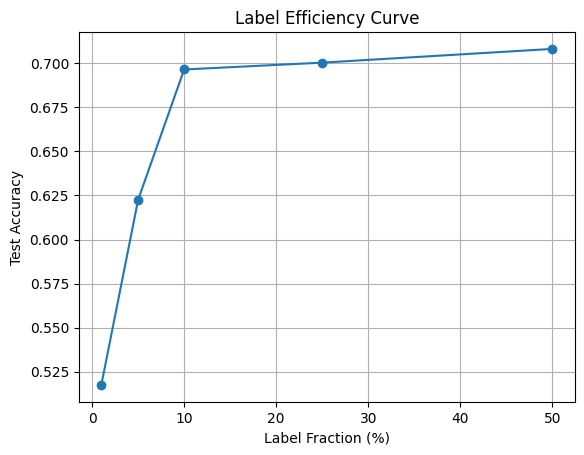

In [17]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression

fractions = [0.01, 0.05, 0.1, 0.25, 0.5]
accuracies = []

for f in fractions:
    sss = StratifiedShuffleSplit(n_splits=1, train_size=f)
    idx, _ = next(sss.split(Xtr, train_labels))
    clf2 = LogisticRegression(max_iter=1000)
    clf2.fit(Xtr[idx], train_labels[idx])
    acc = clf2.score(Xte, test_labels)
    accuracies.append(acc)
    print(f"{int(f*100)}% =", acc)

# -----------------------------
# PLOT LABEL FRACTION VS ACCURACY
# -----------------------------
plt.figure()
plt.plot([f*100 for f in fractions], accuracies, marker='o')
plt.xlabel("Label Fraction (%)")
plt.ylabel("Test Accuracy")
plt.title("Label Efficiency Curve")
plt.grid(True)
plt.show()


# -------- EMBEDDING ANALYSIS --------

In [18]:
import umap
umap.umap_.check_array = lambda X, **kwargs: X   # PATCH for sklearn>=1.7 compatibility

print("\n===== EMBEDDING ANALYSIS =====")

pca = PCA(n_components=2).fit_transform(test_feats)
tsne = TSNE(n_components=2).fit_transform(test_feats)

# correct argument
um_emb = umap.UMAP(n_components=2).fit_transform(test_feats)

plt.scatter(pca[:,0], pca[:,1], c=test_labels, s=5)
plt.title("PCA"); plt.savefig("pca.png"); plt.close()

plt.scatter(tsne[:,0], tsne[:,1], c=test_labels, s=5)
plt.title("t-SNE"); plt.savefig("tsne.png"); plt.close()

plt.scatter(um_emb[:,0], um_emb[:,1], c=test_labels, s=5)
plt.title("UMAP"); plt.savefig("umap.png"); plt.close()

print("Silhouette =", silhouette_score(test_feats, test_labels, metric="cosine"))



===== EMBEDDING ANALYSIS =====
Silhouette = 0.059738714


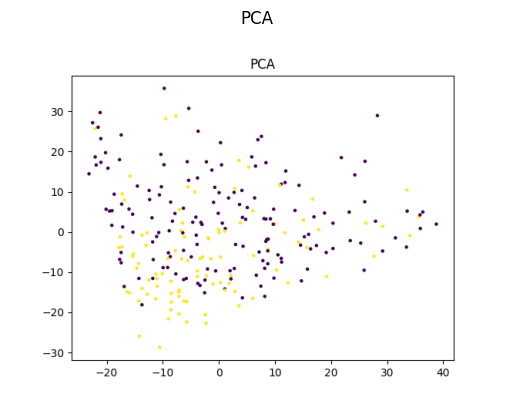

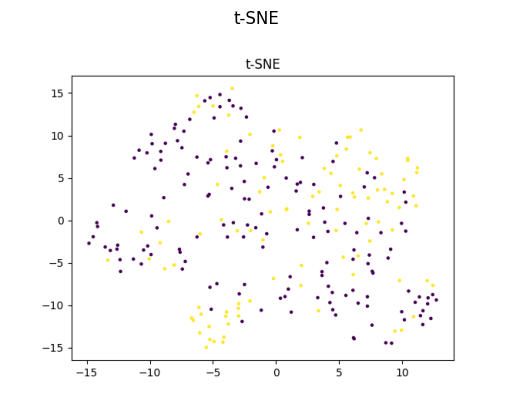

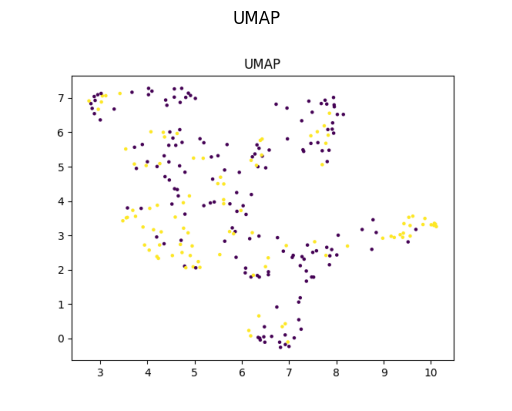

In [19]:
from PIL import Image
import matplotlib.pyplot as plt

# List of saved images
images = ["pca.png", "tsne.png", "umap.png"]
titles = ["PCA", "t-SNE", "UMAP"]

for img_file, title in zip(images, titles):
    img = Image.open(img_file)
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()
